Evaluating models on subjects: ['abstract_algebra', 'anatomy', 'computer_security', 'high_school_mathematics']

Engine: qwen


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Evaluating abstract_algebra...
Average accuracy 30.00 -  abstract algebra
Evaluating anatomy...
Average accuracy 15.00 -  anatomy
Evaluating computer_security...
Average accuracy 25.00 -  computer security
Evaluating high_school_mathematics...
Average accuracy 40.00 -  high school mathematics
Average accuracy: 27.50%

Position Bias Analysis for Engine: qwen
Evaluating abstract_algebra...
Testing with answers at position A...
Average accuracy 30.00 -  abstract algebra
Testing with answers at position B...
Average accuracy 100.00 -  abstract algebra
Testing with answers at position C...
Average accuracy 0.00 -  abstract algebra
Testing with answers at position D...
Average accuracy 30.00 -  abstract algebra
Position accuracies for abstract_algebra: {'A': np.float64(0.3), 'B': np.float64(1.0), 'C': np.float64(0.0), 'D': np.float64(0.3)}
Evaluating anatomy...
Testing with answers at position A...
Average accuracy 0.00 -  anatomy
Testing with answers at position B...
Average accuracy 50.00 

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.2-1B.
401 Client Error. (Request ID: Root=1-67dafc1d-4b4e4244173abeaa3dae293a;106c4efc-d29e-4ea0-a865-72b7b40ebaad)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted. You must have access to it and be authenticated to access it. Please log in.

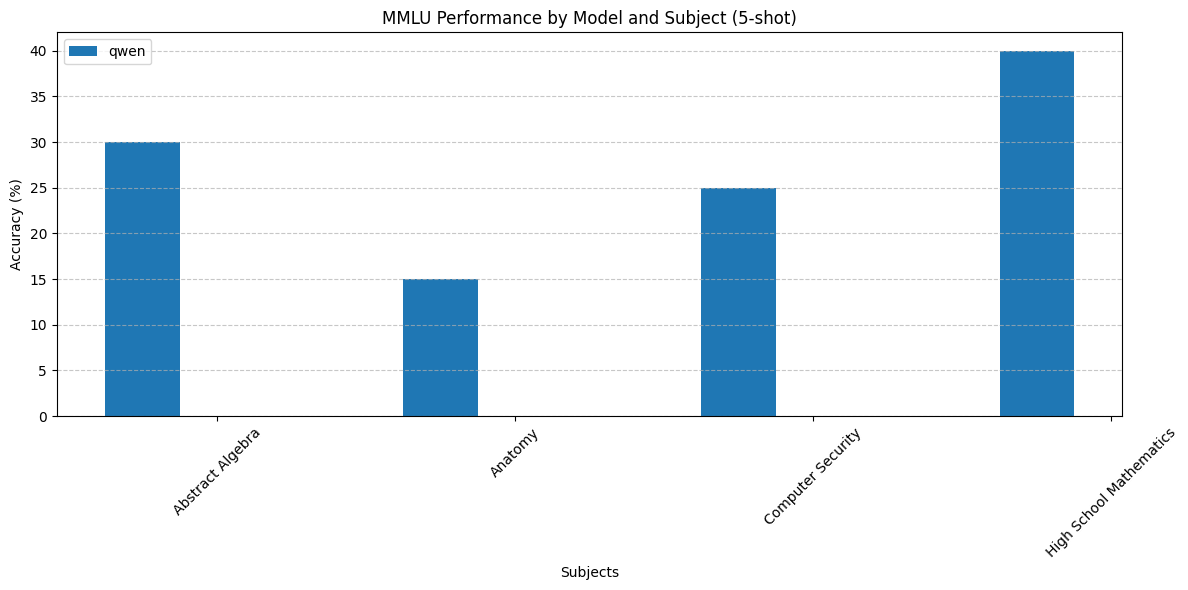

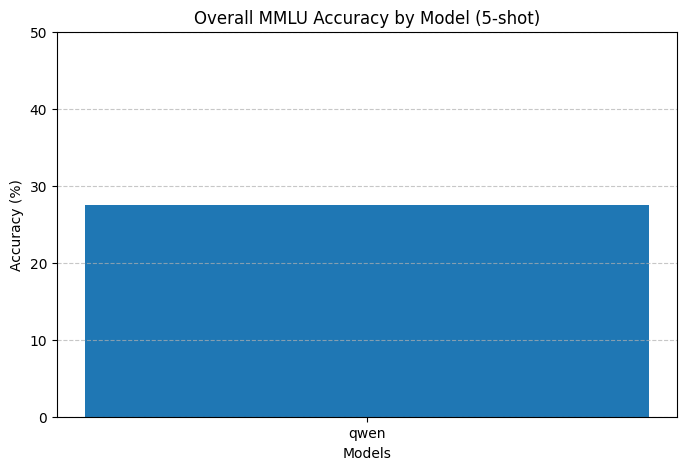

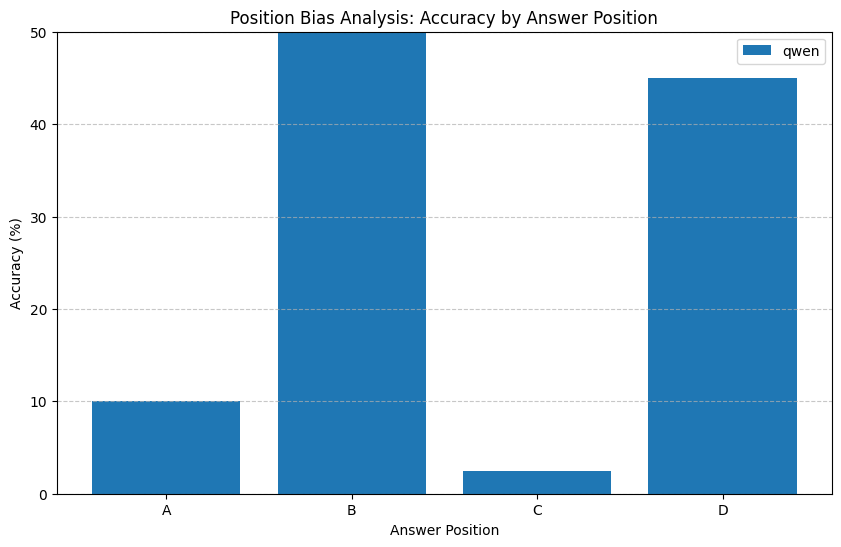

In [ ]:

from LLMs_attack import *

models = ["qwen"]
attacks = [True, False]
    
for model in models:
        for attack in attacks:
                args = argparse.Namespace(
                ntrain=0,
                data_dir="data/MMLU",
                engine=[model],
                n_reduced=None,
                use_subset=False,
                permutation_attack=attack,
                position_permute=False,
                reduce_attack=False,
                load_in_8bit=False,
                )
                print(f"Running main with model={model} and permutation_attack={attack}")
                main(args)
